In [7]:
from os.path import expanduser, join

import numpy as np
from sklearn import utils

import matplotlib.pyplot as plt

from localizer import config, util, visualization, models, keras_helpers

%matplotlib inline

In [8]:
import importlib
for module in (config, util, visualization, models, keras_helpers):
    importlib.reload(module)
    

In [9]:
data_dir = join(expanduser("~"), 'deeplocalizer_data', 'data')

In [10]:
X_train, y_train, X_test, y_test, X_val, y_val = util.load_or_restore_data(data_dir)

Loading data
492544/493414 [============================>.] - ETA: 0s
Shuffling data
493414/493414 [==============================] - 578s     

Splitting validation



In [11]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(493414, 1, 64, 64)
(246707, 1, 64, 64)
(246707, 1, 64, 64)


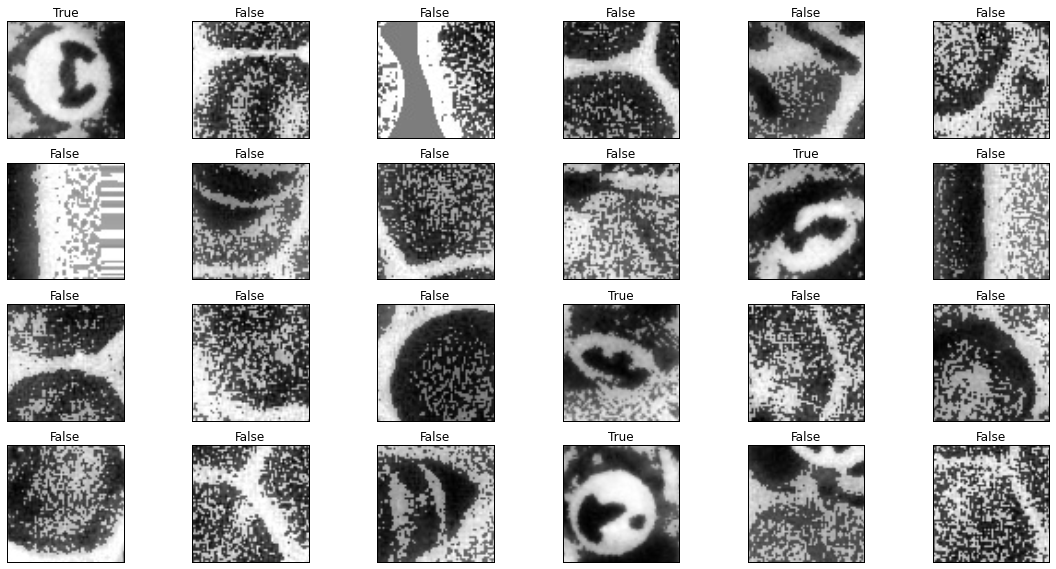

In [12]:
fig = visualization.plot_sample_images(X_train, y_train)

In [13]:
filtersize = (16, 16)

Xs_train = util.resize_data(X_train, filtersize)
Xs_val   = util.resize_data(X_val, filtersize)
Xs_test  = util.resize_data(X_test, filtersize)

print(Xs_train.shape)
print(Xs_test.shape)
print(Xs_val.shape)

246784/246707 [==============================] - 58s    
(493414, 1, 16, 16)
(246707, 1, 16, 16)
(246707, 1, 16, 16)


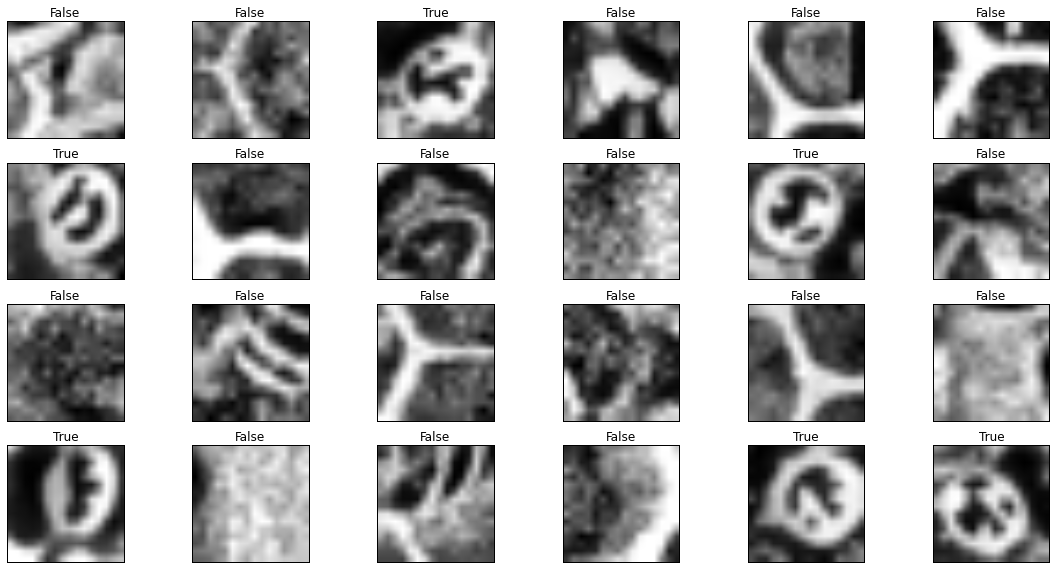

In [14]:
fig = visualization.plot_sample_images(Xs_train, y_train)

In [15]:
saliency_network = models.get_saliency_network(train=True)

In [16]:
saliency_datagen = keras_helpers.get_datagen(Xs_train)
saliency_class_weight = utils.class_weight.compute_class_weight('auto', [0, 1], y_train[:, 1])

In [17]:
saliency_weight_file = join(data_dir, 'weights', 'saliency-weights')
saliency_history = keras_helpers.fit_model(saliency_network, saliency_datagen, Xs_train, y_train, Xs_val, y_val,
                                           saliency_weight_file, saliency_class_weight, batchsize=4096, categorial=False)

Epoch 0
246707/246707 [==============================] - 3s - test loss: 0.0882 - test acc: 1.0000     

Epoch 1
246707/246707 [==============================] - 3s - test loss: 0.0534 - test acc: 1.0000     

Epoch 2
246707/246707 [==============================] - 3s - test loss: 0.0411 - test acc: 1.0000     

Epoch 3
246707/246707 [==============================] - 3s - test loss: 0.0299 - test acc: 1.0000     

Epoch 4
246707/246707 [==============================] - 3s - test loss: 0.0231 - test acc: 1.0000     

Epoch 5
246707/246707 [==============================] - 3s - test loss: 0.0207 - test acc: 1.0000     

Epoch 6
246707/246707 [==============================] - 3s - test loss: 0.0186 - test acc: 1.0000     

Epoch 7
246707/246707 [==============================] - 3s - test loss: 0.0170 - test acc: 1.0000     

Epoch 8
246707/246707 [==============================] - 3s - test loss: 0.0145 - test acc: 1.0000     

Epoch 9
246707/246707 [==============================] 

In [18]:
ys_out = keras_helpers.predict_model(saliency_network, Xs_test, saliency_datagen)

246784/246707 [==============================] - 4s     


('Recall', 0.99501459143968873)
('Precision', 0.16598242610607622)
('Threshold', 0.0012497901916503906)
('F_2', 0.49777119192568037)
('F_0.5', 0.19917186562921077)


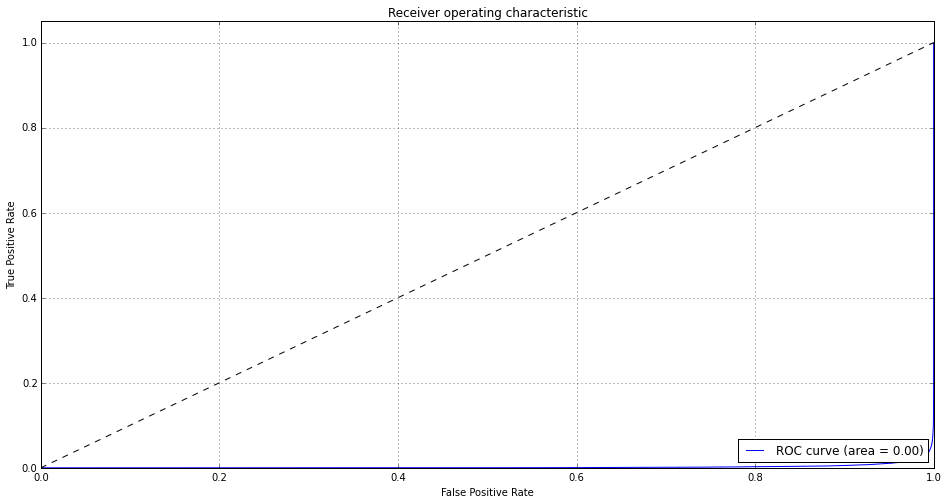

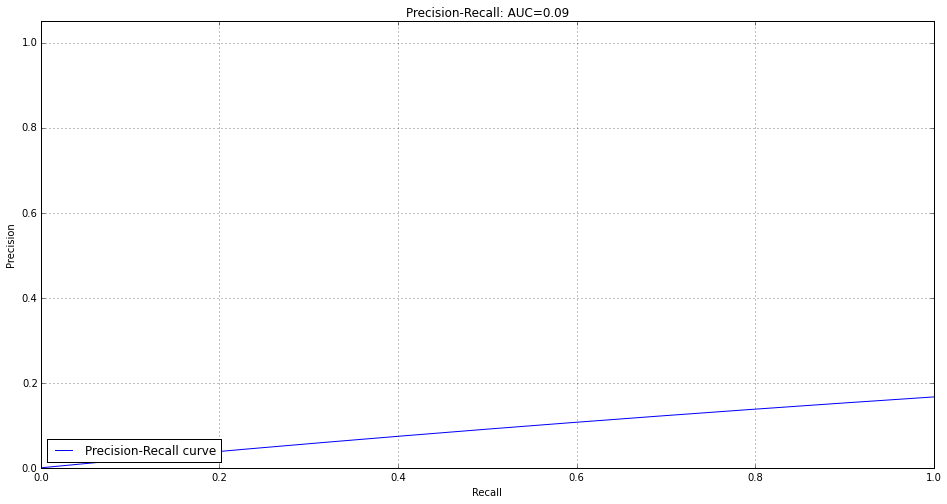

In [19]:
saliency_threshold = keras_helpers.evaluate_model(y_test, ys_out, min_value=0.995, optimize='recall', visualize=True)

In [20]:
saliency_convolution_model = models.get_saliency_network(train=False)


In [21]:
convolution_function = keras_helpers.get_convolution_function(saliency_network, saliency_convolution_model)

In [22]:
image_path = join(expanduser("~"), 'deeplocalizer_data')
with open(join(image_path, 'test.txt'), 'r') as f:
    image_files = [line.split('\n')[0] for line in f.readlines()]

In [23]:
imfile = image_files[0]
image, image_filtersize, targetsize = util.preprocess_image(join(image_path, imfile), filtersize)

In [24]:
%%%timeit
convolution_function(image_filtersize.reshape((1, 1, image_filtersize.shape[0], image_filtersize.shape[1])))

10 loops, best of 3: 51.6 ms per loop


In [25]:
saliency = convolution_function(image_filtersize.reshape((1, 1, image_filtersize.shape[0], image_filtersize.shape[1])))

/usr/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


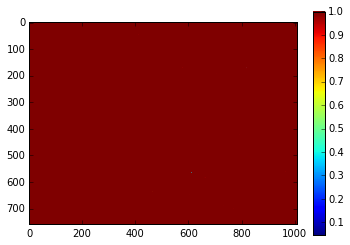

In [26]:
plt.imshow(saliency[0][0, 0])
plt.colorbar()